In [202]:
columns_titles = ["ID",	"User",	"Text",	"Sentiment",	"lowercase",	"split", "token",	"contraceptions",	"noPunctuation","nostop"]

df_reorder=df.reindex(columns=columns_titles)
#df = df_reorder

#Baseline Model

The baseline model is a simple model that can be used for making predictions. The baseline accuracy is the metric that's used to compare the performance of the actual algorithm. The base line model that I have used is the model from the demo that was provided.

In [2]:
#Load the libraries
import numpy as np
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from google.colab import files
import io

In [3]:
data_to_load = files.upload()
df = pd.read_csv(io.BytesIO(data_to_load['training_data (1).csv']))

Saving training_data (1).csv to training_data (1).csv


In [ ]:
#prints top few samples the dataset
df.head()

,ID,User,Text,Sentiment
0,864192,Carly_FTS,I *heart* filling up @dennisschaub desk 1 it...,1
1,523691,Open_Sourcing,"#SocioMat - people create prettier, younger an...",1
2,584154,xxcharlx,no way i dont want the tour to end,0
3,1527961,andreapuddu,@HemalRadia Hi Amazing Brother! Sending Limitl...,1
4,28609,umbec,@flockmaster they are chocolate,1


In [ ]:
df.shape

(1000000, 4)

In [ ]:
# Used to split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df.Text,df.Sentiment,test_size=0.33,random_state=42) #splitting the dataset into training and testing

In [ ]:
#check the dimensions
print("Number of training samples: {}".format(x_train.shape[0]))
print("Number of testing samples: {}".format(x_test.shape[0])) 

Number of training samples: 670000
Number of testing samples: 330000


In [ ]:
#bag of words model to convert text to numbers
cv=CountVectorizer(binary=False)


In [ ]:
#transformed train reviews
train_reviews = cv.fit_transform(x_train)
#transformed test reviews
test_reviews = cv.transform(x_test)

In [ ]:
#The data preparation is done, steps below prepare a sample model
#preparing the model
lr=LogisticRegression()
#training the model for Bag of words
lr_bow=lr.fit(train_reviews,y_train)
print(lr_bow)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
#Accuracy score for bag of words
lr_bow_predict = lr.predict(test_reviews)
lr_bow_score = accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.7970333333333334


The accuracy from the baseline model is 79%. The real model/algorithm should be higher since in this model we have not preprocessed the data in any way.

#Method 1 - Scikit Learn




For the Scikit Learn the model that I have used are SVM and Logistic regression. They are a popular choice when doing sentiment analysis and are known to achieve faily high accuracies as well. The part that's different from the baseline model is that in this model there preprocessing of data. Here is an overview of the steps that I have taken:
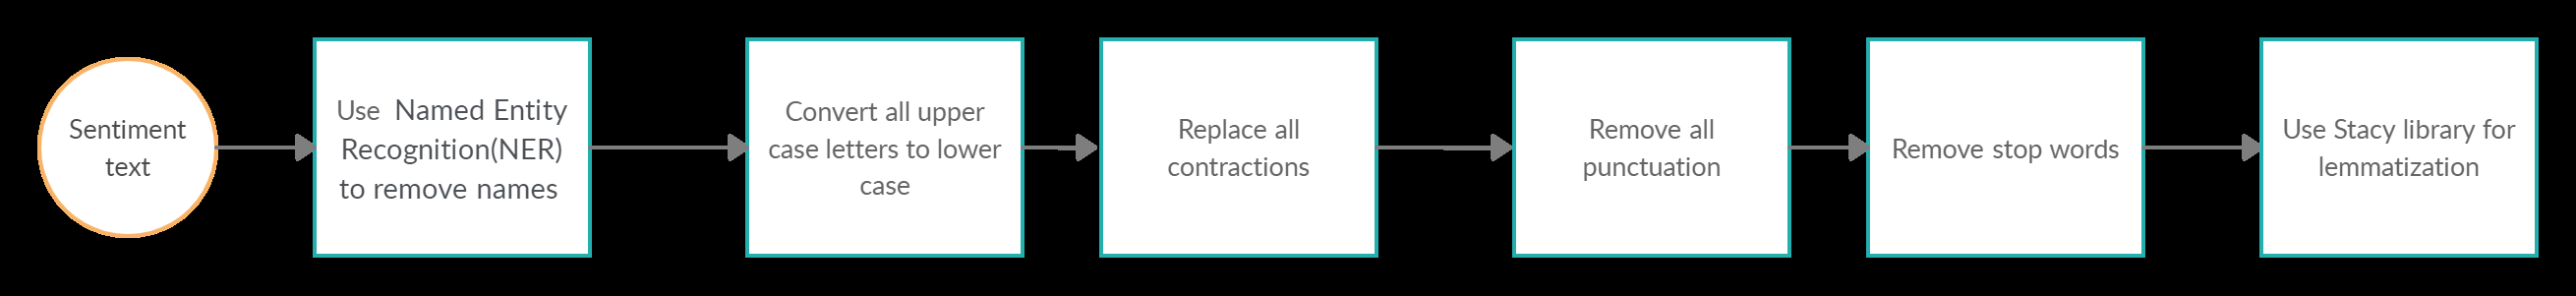

**1.NER-removing of names/places/countries etc.**

Removing names,places, countries etc is useful in sentiment analysis since these words do not add much value to the sematic meaning behind the text. This step is done before all the steps since the capitilization and grammer matter while categorizing the words. I used the Spacy library to categorize the words into different groups such as name, countries, organization etc. Then I checked the label of each word and removed the ones that will not aid in sentiment analysis.

In [5]:
import spacy

In [6]:
nlp = spacy.load('en_core_web_sm') 
  
df['ner'] = df['Text']
def NER(sentence):
  doc = nlp(sentence) 
  #sentence = sentence.split()
  for ent in doc.ents: 
    # Removing names, countries, money, nationalities 
    if(ent.label_=="PERSON" or  ent.label=="GPE" or ent.label=="MONEY" or ent.label=="NORP" or ent.label=="LOC" or ent.label=="ORG" ):
      sentence = sentence.replace(str(ent),"")  
  return sentence

size = len(df['ID'])
for i in range(size):
  df['ner'][i]=NER(df['Text'][i])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [7]:
df.head()

,ID,User,Text,Sentiment,ner
0,864192,Carly_FTS,I *heart* filling up @dennisschaub desk 1 it...,1,I *heart* filling up @dennisschaub desk 1 it...
1,523691,Open_Sourcing,"#SocioMat - people create prettier, younger an...",1,"# - people create prettier, younger and better..."
2,584154,xxcharlx,no way i dont want the tour to end,0,no way i dont want the tour to end
3,1527961,andreapuddu,@HemalRadia Hi Amazing Brother! Sending Limitl...,1,@HemalRadia Hi Amazing Brother! (((Love))) Yo...
4,28609,umbec,@flockmaster they are chocolate,1,@flockmaster they are chocolate


**2. Convert all upper case letters in sentences to lower case**

This step is needed for other preprocessing steps below

In [8]:

df['lowercase'] = df['ner'].apply(lambda x: " ".join(word.lower() for word in x.split()))

In [9]:
df.head()

,ID,User,Text,Sentiment,ner,lowercase
0,864192,Carly_FTS,I *heart* filling up @dennisschaub desk 1 it...,1,I *heart* filling up @dennisschaub desk 1 it...,i *heart* filling up @dennisschaub desk 1 it m...
1,523691,Open_Sourcing,"#SocioMat - people create prettier, younger an...",1,"# - people create prettier, younger and better...","# - people create prettier, younger and better..."
2,584154,xxcharlx,no way i dont want the tour to end,0,no way i dont want the tour to end,no way i dont want the tour to end
3,1527961,andreapuddu,@HemalRadia Hi Amazing Brother! Sending Limitl...,1,@HemalRadia Hi Amazing Brother! (((Love))) Yo...,@hemalradia hi amazing brother! (((love))) you...
4,28609,umbec,@flockmaster they are chocolate,1,@flockmaster they are chocolate,@flockmaster they are chocolate


**3.Replace contractions with base words**

This stepm replaces contractions with their base words so don't will be replaced with do not. This useful for text standadization and this also removes words with similiar meaning.

In [10]:
pip install contractions

     |████████████████████████████████| 245kB 3.7MB/s 
     |████████████████████████████████| 317kB 7.7MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81708 sha256=4ab382cebe603a98060941ae1fa3fcbfe498011b58bb901f3c1af3c96c60e1a8
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [11]:
import contractions

df['split']=df['lowercase'].apply(lambda x : filter(None,x.split(" ")))
df['token']=df['split'].apply(lambda x : [contractions.fix(y) for y in x])
df['contraceptions']=df['token'].apply(lambda x : " ".join(x))


In [12]:
df.head()

,ID,User,Text,Sentiment,ner,lowercase,split,token,contraceptions
0,864192,Carly_FTS,I *heart* filling up @dennisschaub desk 1 it...,1,I *heart* filling up @dennisschaub desk 1 it...,i *heart* filling up @dennisschaub desk 1 it m...,<filter object at 0x7f9ac9416f60>,"[i, *heart*, filling, up, @dennisschaub, desk,...",i *heart* filling up @dennisschaub desk 1 it m...
1,523691,Open_Sourcing,"#SocioMat - people create prettier, younger an...",1,"# - people create prettier, younger and better...","# - people create prettier, younger and better...",<filter object at 0x7f9ac9cb91d0>,"[#, -, people, create, prettier,, younger, and...","# - people create prettier, younger and better..."
2,584154,xxcharlx,no way i dont want the tour to end,0,no way i dont want the tour to end,no way i dont want the tour to end,<filter object at 0x7f9ac9cb9400>,"[no, way, i, do not, want, the, tour, to, end]",no way i do not want the tour to end
3,1527961,andreapuddu,@HemalRadia Hi Amazing Brother! Sending Limitl...,1,@HemalRadia Hi Amazing Brother! (((Love))) Yo...,@hemalradia hi amazing brother! (((love))) you...,<filter object at 0x7f9ac9cb96d8>,"[@hemalradia, hi, amazing, brother!, (((love))...",@hemalradia hi amazing brother! (((love))) you...
4,28609,umbec,@flockmaster they are chocolate,1,@flockmaster they are chocolate,@flockmaster they are chocolate,<filter object at 0x7f9ac9cb97b8>,"[@flockmaster, they, are, chocolate]",@flockmaster they are chocolate


**3. Remove all punctuation**

Punctuation does not add any value to sentiment analysis and therefore the texts are stripped of any punctuation.

In [13]:

df['noPunctuation']= df['contraceptions'].str.replace('[^\w\s]', '')

In [14]:
df.head()

,ID,User,Text,Sentiment,ner,lowercase,split,token,contraceptions,noPunctuation
0,864192,Carly_FTS,I *heart* filling up @dennisschaub desk 1 it...,1,I *heart* filling up @dennisschaub desk 1 it...,i *heart* filling up @dennisschaub desk 1 it m...,<filter object at 0x7f9ac9416f60>,"[i, *heart*, filling, up, @dennisschaub, desk,...",i *heart* filling up @dennisschaub desk 1 it m...,i heart filling up dennisschaub desk 1 it mean...
1,523691,Open_Sourcing,"#SocioMat - people create prettier, younger an...",1,"# - people create prettier, younger and better...","# - people create prettier, younger and better...",<filter object at 0x7f9ac9cb91d0>,"[#, -, people, create, prettier,, younger, and...","# - people create prettier, younger and better...",people create prettier younger and better lo...
2,584154,xxcharlx,no way i dont want the tour to end,0,no way i dont want the tour to end,no way i dont want the tour to end,<filter object at 0x7f9ac9cb9400>,"[no, way, i, do not, want, the, tour, to, end]",no way i do not want the tour to end,no way i do not want the tour to end
3,1527961,andreapuddu,@HemalRadia Hi Amazing Brother! Sending Limitl...,1,@HemalRadia Hi Amazing Brother! (((Love))) Yo...,@hemalradia hi amazing brother! (((love))) you...,<filter object at 0x7f9ac9cb96d8>,"[@hemalradia, hi, amazing, brother!, (((love))...",@hemalradia hi amazing brother! (((love))) you...,hemalradia hi amazing brother love your way is...
4,28609,umbec,@flockmaster they are chocolate,1,@flockmaster they are chocolate,@flockmaster they are chocolate,<filter object at 0x7f9ac9cb97b8>,"[@flockmaster, they, are, chocolate]",@flockmaster they are chocolate,flockmaster they are chocolate


**4.Remove stopwords**

Stop words such as I, my, he, she also does not add any value when determining the sentiment of a text. I used the nltk library to obtain a list of 179 stopwords. What I noticed is that the accuracy slightly decreased after using these stopwords and the reason for this is that some stop words like no, shouldn't, not actually add negative sentiment. For example a sentence like "No! I wont do it", removing the no will make it difficult to guess the sentiment of this sentence. So to avoid this issue I removed some stopwords that could possible have negative sentiment from the list of stopwords.

In [15]:
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

True

In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


I removed some words from the stop words set since they can add value to the sentiment. For example 'no' may give negative sentiment in a sentence and if its removed, then the sentiment is lost as well.

In [18]:
print(stop_words)
stop_words.remove('no')
stop_words.remove("weren't")
stop_words.remove('don')
stop_words.remove('didn')
stop_words.remove("couldn't")
stop_words.remove('weren')
stop_words.remove("shouldn't")
stop_words.remove("didn't")
stop_words.remove('wasn')
stop_words.remove("shan't")
stop_words.remove("haven't")
stop_words.remove('shouldn')
stop_words.remove('needn')
stop_words.remove("needn't")

stop_words.remove("aren't")
stop_words.remove("wasn't")
stop_words.remove("hasn't")
stop_words.remove("isn't")
stop_words.remove('doesn')
stop_words.remove("wouldn't")
stop_words.remove('aren')
stop_words.remove('couldn')
stop_words.remove('mustn')

stop_words.remove('nor')
stop_words.remove('mightn')
stop_words.remove('wouldn')
stop_words.remove('isn')
stop_words.remove("doesn't")
stop_words.remove('against')
stop_words.remove("mustn't")
stop_words.remove("hadn't")
stop_words.remove('haven')
stop_words.remove("mightn't")
stop_words.remove("won't")
stop_words.remove("don't")
print(stop_words)
df['nostop'] = df['noPunctuation'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

{'weren', 'for', 'being', 'under', 'didn', 'about', 'any', 'before', 'through', 'over', 'if', 'ourselves', "wasn't", 'whom', 'above', 'too', 'yourself', 're', 'yours', 'can', 'y', "mightn't", 'or', 'until', "haven't", 'hadn', 'when', "mustn't", "shan't", "needn't", 'were', 'between', 'me', 'where', 'her', 'they', 'more', 'there', 'how', 'him', "you'd", 'should', 'them', 'few', 'doesn', 'ma', "you're", 'as', 'wasn', 'ours', 'theirs', "she's", 'what', 'aren', 'so', 'my', "wouldn't", 'hasn', 'then', 'do', 'on', 'because', 'll', 'that', 'below', 'and', 'but', 'during', 'its', 'are', 'at', 'some', 'in', 'had', 'who', 'all', 'into', "hasn't", "won't", 'here', 'he', 'we', "that'll", 'o', "isn't", 'myself', 'm', 'by', 'shouldn', 'a', 'mightn', 'she', 'other', "shouldn't", 'won', 'has', "hadn't", 'been', 'against', 'you', 'just', 'both', 'am', 'now', 'which', 'doing', 'wouldn', 'up', 'down', 'hers', 'these', "you've", 'each', 'our', 'ain', 'is', "you'll", 'itself', 'haven', 'very', "aren't", 'n

In [19]:
df.head()

,ID,User,Text,Sentiment,ner,lowercase,split,token,contraceptions,noPunctuation,nostop
0,864192,Carly_FTS,I *heart* filling up @dennisschaub desk 1 it...,1,I *heart* filling up @dennisschaub desk 1 it...,i *heart* filling up @dennisschaub desk 1 it m...,<filter object at 0x7f9ac9416f60>,"[i, *heart*, filling, up, @dennisschaub, desk,...",i *heart* filling up @dennisschaub desk 1 it m...,i heart filling up dennisschaub desk 1 it mean...,heart filling dennisschaub desk 1 means sales ...
1,523691,Open_Sourcing,"#SocioMat - people create prettier, younger an...",1,"# - people create prettier, younger and better...","# - people create prettier, younger and better...",<filter object at 0x7f9ac9cb91d0>,"[#, -, people, create, prettier,, younger, and...","# - people create prettier, younger and better...",people create prettier younger and better lo...,people create prettier younger better looking ...
2,584154,xxcharlx,no way i dont want the tour to end,0,no way i dont want the tour to end,no way i dont want the tour to end,<filter object at 0x7f9ac9cb9400>,"[no, way, i, do not, want, the, tour, to, end]",no way i do not want the tour to end,no way i do not want the tour to end,no way want tour end
3,1527961,andreapuddu,@HemalRadia Hi Amazing Brother! Sending Limitl...,1,@HemalRadia Hi Amazing Brother! (((Love))) Yo...,@hemalradia hi amazing brother! (((love))) you...,<filter object at 0x7f9ac9cb96d8>,"[@hemalradia, hi, amazing, brother!, (((love))...",@hemalradia hi amazing brother! (((love))) you...,hemalradia hi amazing brother love your way is...,hemalradia hi amazing brother love way radiant...
4,28609,umbec,@flockmaster they are chocolate,1,@flockmaster they are chocolate,@flockmaster they are chocolate,<filter object at 0x7f9ac9cb97b8>,"[@flockmaster, they, are, chocolate]",@flockmaster they are chocolate,flockmaster they are chocolate,flockmaster chocolate


**5. Lemmatization**

Lemmatization is getting to the base form of a word by removing affixes. For example the root word for swimming,swims, swimed are all swim. This is important as it reduces the complexity of the model by grouping words with the same meaning together as the root word.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

df['lemma'] = df['nostop'].apply(lambda x: [y.lemma_ for y in  nlp(x)])


In [ ]:
df['lemmas'] = df['lemma'].apply(lambda x : " ".join(x))

In [204]:
df.head()

,ID,User,Text,Sentiment,lowercase,split,token,contraceptions,noPunctuation,nostop,lemma,lemmas
0,864192,Carly_FTS,I *heart* filling up @dennisschaub desk 1 it...,1,i *heart* filling up @dennisschaub desk 1 it m...,<filter object at 0x7f1e2551d5f8>,"[i, *heart*, filling, up, @dennisschaub, desk,...",i *heart* filling up @dennisschaub desk 1 it m...,i heart filling up dennisschaub desk 1 it mean...,heart filling dennisschaub desk 1 means sales ...,"[i, heart, fill, up, dennisschaub, desk, 1, -P...",i heart fill up dennisschaub desk 1 -PRON- mea...
1,523691,Open_Sourcing,"#SocioMat - people create prettier, younger an...",1,"#sociomat - people create prettier, younger an...",<filter object at 0x7f1e2551d780>,"[#sociomat, -, people, create, prettier,, youn...","#sociomat - people create prettier, younger an...",sociomat people create prettier younger and b...,sociomat people create prettier younger better...,"[sociomat, , people, create, pretty, young, a...",sociomat people create pretty young and bett...
2,584154,xxcharlx,no way i dont want the tour to end,0,no way i dont want the tour to end,<filter object at 0x7f1e2551d550>,"[no, way, i, do not, want, the, tour, to, end]",no way i do not want the tour to end,no way i do not want the tour to end,no way want tour end,"[no, way, i, do, not, want, the, tour, to, end]",no way i do not want the tour to end
3,1527961,andreapuddu,@HemalRadia Hi Amazing Brother! Sending Limitl...,1,@hemalradia hi amazing brother! sending limitl...,<filter object at 0x7f1e2574ef28>,"[@hemalradia, hi, amazing, brother!, sending, ...",@hemalradia hi amazing brother! sending limitl...,hemalradia hi amazing brother sending limitles...,hemalradia hi amazing brother sending limitles...,"[hemalradia, hi, amazing, brother, send, limit...",hemalradia hi amazing brother send limitless l...
4,28609,umbec,@flockmaster they are chocolate,1,@flockmaster they are chocolate,<filter object at 0x7f1e2574ed68>,"[@flockmaster, they, are, chocolate]",@flockmaster they are chocolate,flockmaster they are chocolate,flockmaster chocolate,"[flockmaster, -PRON-, be, chocolate]",flockmaster -PRON- be chocolate


**Training and testing split**

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(df.lemmas,df.Sentiment,test_size=0.33,random_state=42) #splitting the dataset into training and testing

**New model for conversion from text to words**

I used TfidfVectorizer for converting the text to numbers instead of the CountVectorizer because TfidfVectorizer applies more weight to rare words instead of high frequency words. Also TfidfVectorizer increased the accuracy.

In [ ]:
#bag of words model to convert text to numbers

cv =TfidfVectorizer(min_df=0.0, max_df=1.0, ngram_range=(0,4),
                     sublinear_tf=True, max_features=100000)

In [ ]:
#transformed train reviews
train_reviews = cv.fit_transform(x_train)
#transformed test reviews
test_reviews = cv.transform(x_test)

In [ ]:
#The data preparation is done, steps below prepare a sample model
#preparing the model
lr= LogisticRegression(solver='lbfgs',class_weight='balanced', max_iter=10000)
#training the model for Bag of words
lr_bow=lr.fit(train_reviews,y_train)
print(lr_bow)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)


In [ ]:
#Accuracy score for bag of words
lr_bow_predict = lr.predict(test_reviews)
lr_bow_score = accuracy_score(y_test,lr_bow_predict)
print("lr_bow_score :",lr_bow_score)

lr_bow_score : 0.8140575757575758


The final accuracy that I was able to achieve is 81% after data processing.

#Method 2 : Using Deep learning and Glove Embeddings

*Note:This code has been modified from my APS360(Artificial Intelligence Fundermentals) class

Glove embeddings store more useful information regarding the context of words compared to the TfidfVectorizer method which is useful since we are trying to find the sentiment of the text. I used the twitter.27B corpus for my embeddings since the training data that we use is similiar in structure(length, spelling etc) to tweets from twitter. Deep learning for sentiment analysis is useful since it can be more accurate when dealing with very large datasets.

In [ ]:
#setup Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load csv file from Google Drive

In [ ]:
import csv

# file location (make sure to use your file location)
file_dir = '/content/drive/My Drive/aiHack/'

# load csv file
def get_data():
    return csv.reader(open(file_dir + "training_data (1).csv","rt", encoding="latin-1"))


Preprocess and segment text

In [ ]:
import torchtext
import re

def split_tweet(tweet):
    #Remove punctuation
    tweet = re.sub(r'[^\w\s]','',tweet)
    # Convert all capital letters to lowercase
    tweet = tweet.lower().split()
    
    filtered_sentence = [w for w in tweet if not w in stop_words] 
    filtered_sentence = [] 

    # Remove stopwords and digits
    for w in tweet: 
      if w not in stop_words and w.isdigit()==False: 
        filtered_sentence.append(w)

    return filtered_sentence
# split_tweet("hello; don't you know? 23456")

Use Twitter.27B corpus for Glove embeddings 

In [ ]:
#dimensions of embeddings is 100 
glove = torchtext.vocab.GloVe(name="twitter.27B", dim=100)


Get the embeddings for the words in the text and sort them into train, test and validation

In [180]:
def get_tweet_words(glove_vector):
    train, valid, test = [], [], []
    for i, line in enumerate(get_data()):
        if i % 29 == 0:
            tweet = line[-2]
            idxs = [glove_vector.stoi[w]        # lookup the index of word, word is stored in dictionary
                    for w in split_tweet(tweet)
                    if w in glove_vector.stoi] # keep words that has an embedding
            if not idxs: # ignore tweets without any word with an embedding
                continue
            idxs = torch.tensor(idxs) # convert list to pytorch tensor
            # Check the label of text
            if(line[-1]=='0'):
              label = torch.tensor(0)
            else:
              label = torch.tensor(1)

            # Split data in train test and validation 
            if i % 5 < 3:
                train.append((idxs, label))
            elif i % 5 == 4:
                valid.append((idxs, label))
            else:
                test.append((idxs, label))
    return train, valid, test

train, valid, test = get_tweet_words(glove)

Model architecture for GRU. I used a GRU since it can capture longterm dependancies which is not possible with a RNN.

In [181]:
import torch.nn.functional as F
class TweetRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(TweetRNN, self).__init__()
        self.emb = nn.Embedding.from_pretrained(glove.vectors)# embedding values from indexes
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    def forward(self, x):
        # Look up the embedding
        x = self.emb(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
       
        # Pass the output of the last time step to the classifier
        out = self.fc2(out[:, -1, :])
        return out

model = TweetRNN(50, 50, 2)

Batch and pad the texts based on their length. Texts of similiar length are batched together.

In [182]:
import random

class TweetBatcher:
    def __init__(self, tweets, batch_size=32, drop_last=False):
        # store tweets by length
        self.tweets_by_length = {}
        for words, label in tweets:
            # compute the length of the tweet
            wlen = words.shape[0]
            # put the tweet in the correct key inside self.tweet_by_length
            if wlen not in self.tweets_by_length:
                self.tweets_by_length[wlen] = []
            self.tweets_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of tweets of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    tweets,
                                    batch_size=batch_size,
                                    shuffle=True,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, tweets in self.tweets_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every tweet length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

Function to calculate the accuracy of the train,test and validation dataset

In [ ]:
def get_accuracy(model, data_loader):
    correct, total = 0, 0
    for tweets, labels in data_loader:
        output = model(tweets)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

test_loader = TweetBatcher(test, batch_size=64, drop_last=False)
get_accuracy(model, test_loader)

Training code for GRU

In [187]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for tweets, labels in train:
            optimizer.zero_grad()
            pred = model(tweets)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")    
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1; Loss 0.611741; Train Acc 0.698667; Val Acc 0.692801
Epoch 2; Loss 0.487703; Train Acc 0.736424; Val Acc 0.732877
Epoch 3; Loss 0.505993; Train Acc 0.752424; Val Acc 0.752987
Epoch 4; Loss 0.504096; Train Acc 0.760364; Val Acc 0.754590
Epoch 5; Loss 0.435502; Train Acc 0.761333; Val Acc 0.759108
Epoch 6; Loss 0.493080; Train Acc 0.766121; Val Acc 0.755902
Epoch 7; Loss 0.445877; Train Acc 0.769212; Val Acc 0.756776
Epoch 8; Loss 0.485047; Train Acc 0.772121; Val Acc 0.760857
Epoch 9; Loss 0.435109; Train Acc 0.774242; Val Acc 0.761731
Epoch 10; Loss 0.487947; Train Acc 0.779697; Val Acc 0.762023
Epoch 11; Loss 0.422161; Train Acc 0.777333; Val Acc 0.763189
Epoch 12; Loss 0.433963; Train Acc 0.783394; Val Acc 0.766395
Epoch 13; Loss 0.499875; Train Acc 0.783636; Val Acc 0.769018
Epoch 14; Loss 0.455101; Train Acc 0.785333; Val Acc 0.764063
Epoch 15; Loss 0.424007; Train Acc 0.786242; Val Acc 0.769601
Epoch 16; Loss 0.462335; Train Acc 0.790788; Val Acc 0.769164
Epoch 17; Loss 0.

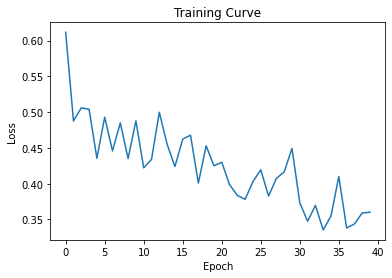

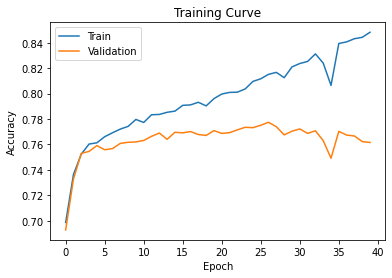

0.7627044392523364

In [188]:
model = TweetRNN(100, 100, 2)
train_loader = TweetBatcher(train, batch_size=500, drop_last=True)
valid_loader = TweetBatcher(valid, batch_size=500, drop_last=False)
train_rnn_network(model, train_loader, valid_loader, num_epochs=40, learning_rate=.0005)
get_accuracy(model, test_loader)


The final accuracy that was achieved after playing around with several hyperparameters(model architecture, GRU vs LSTM vs RNN, learning rate etc) was 76%.

#Best Model and Final testing

The best model that gave the highest test score was the logistic regression model. This was not suprising since neural networks need a lot of data. Below I have followed the same data processing steps for the test set as I did for the training set but have not included all the intermediate steps in the dataframe and cv file.

In [ ]:
data_to_load = files.upload()
df = pd.read_csv(io.BytesIO(data_to_load['contestant_judgment.csv']))

In [ ]:
nlp = spacy.load('en_core_web_sm') 
  
df['Text'] = df['Text']
def NER(sentence):
  doc = nlp(sentence) 
  #sentence = sentence.split()
  for ent in doc.ents: 
    # Removing names, countries, money, nationalities 
    if(ent.label_=="PERSON" or  ent.label=="GPE" or ent.label=="MONEY" or ent.label=="NORP" or ent.label=="LOC" or ent.label=="ORG" ):
      sentence = sentence.replace(str(ent),"")  
  return sentence

size = len(df['ID'])
for i in range(size):
  df['Text'][i]=NER(df['Text'][i])

In [ ]:

df['Text'] = df['Text'].apply(lambda x: " ".join(word.lower() for word in x.split()))

In [ ]:
df['Text'] = df['Text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

In [ ]:
import contractions

df['Text']=df['Text'].apply(lambda x : filter(None,x.split(" ")))
df['Text']=df['Text'].apply(lambda x : [contractions.fix(y) for y in x])
df['Text']=df['Text'].apply(lambda x : " ".join(x))

In [ ]:
df['Text'] = df['Text'].apply(lambda x: [y.lemma_ for y in  nlp(x)])
df['lemmas'] = df['lemma'].apply(lambda x : " ".join(x))

In [ ]:
final_test = df.Text
final_reviews = cv.transform(final_test)

In [ ]:

lr_bow_predict = lr.predict(final_reviews)


In [ ]:
# add the sentiment column with the sentiment predictions from the model
df.insert(3 , "sentiment", lr_bow_predict)

In [ ]:
df.to_csv('final2.csv', index=False, header=True)